Rock - Paper - Scissors 
=================

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output

intX = tf.int32
floatX = tf.float32

In [2]:
batch_size = 256              ## batch size 
num_steps = 8                 ## how far back to propagate the gradient in rnn 
state_size = 16               ## size of the hidden state of rnn cell 
learning_rate = 0.1           ## learning rate for the optimizer
epochs = 2                    ## number of epochs

gen_data_size = 200000        ## size of generated data

### Generate some data

In [9]:
def gen_data(size = gen_data_size): 
    """ 
    Generate rock - paper - scissors game sequence 
    Both players have random strategy 
    
    Args: 
    size -- A `int`, number of games 
    
    Returns: 
    x, y -- Two `np.array(int)` arrays, each containing `size` numbers 
        from the set {0, 1, 2} which stand for {rock, paper, scissors} 
        respectively 
    """
    x, y = (np.random.choice(3, size) for i in (0, 1))
    return x, y

In [4]:
def gen_data_non_random(size = gen_data_size): 
    """
    Generate rock - paper - scissors game sequence 
    Opponent repeats rock - paper - scissors over and over 
    
    Args: 
    size -- A `int`, number of games
    
    Returns: 
    x, y -- Two `np.array(int)` arrays, each containing `size` numbers 
        from the set {0, 1, 2} which stand for {rock, paper, scissors} 
        respectively 
    """
    x = np.random.choice(3, size)
    y = np.tile([0,1,2], size // 3 + 1)[:size] 
    return x, y

In [5]:
def gen_batch(raw_data, batch_size = batch_size, num_steps = num_steps): 
    """
    Creates generator of batched data 
    
    Args: 
    raw_data -- A `pair` of `np.array` of shape (None,), result of `gen_data()`
    batch_size -- A `int`, size of the batch 
    num_steps -- A `int`, how many steps should we propagate the gradient back
    
    Returns: 
    x, y, y_next -- A triple of np.array of shape batch_size x num_steps 
        containing values {0, 1, 2}. The arrays represent my moves, opponents 
        moves and opponents next moves. 
    """
    data_length = len(raw_data[0])
    batch_length = data_length // batch_size 
    data_x, data_y = [raw_data[i][0 : batch_size * batch_length].reshape(batch_size, batch_length) \
                    for i in (0, 1)]
    data_y_next = np.pad(data_y, ((0,0),(0,1)), "constant")[:, 1:]
    
    epoch_size = batch_length // num_steps
    for i in range(epoch_size): 
        x = data_x[:, i * num_steps : (i+1) * num_steps]
        y = data_y[:, i * num_steps : (i+1) * num_steps]
        y_next = data_y_next[:, i * num_steps : (i+1) * num_steps]
        yield x, y, y_next

### Build the Model

In [6]:
## Inputs 
x = tf.placeholder(intX, [batch_size, num_steps], name = "my_moves")
y = tf.placeholder(intX, [batch_size, num_steps], name = "opponents_moves")
y_next = tf.placeholder(intX, [batch_size, num_steps], name = "opponents_next_moves")

## One hot representations of inputs 
x_one_hot = tf.one_hot(x, depth = 3, name = "y_one_hot")
y_one_hot = tf.one_hot(y, depth = 3, name = "y_one_hot")
y_next_one_hot = tf.one_hot(y_next, depth = 3, name = "y_next_one_hot")
xy_one_hot = tf.concat([x_one_hot, y_one_hot], axis=2, name = "xy_one_hot")

## RNN
cell = tf.nn.rnn_cell.LSTMCell(state_size)
init_state = cell.zero_state(batch_size, floatX)

rnn_outputs, final_state = tf.nn.dynamic_rnn(cell = cell,  
                                             inputs = xy_one_hot,  
                                             initial_state = init_state)

logits = tf.layers.dense(inputs = rnn_outputs, units = 3, activation = None, name = "logits")
predictions = tf.nn.softmax(logits, name = "predictions")

## Loss and Optimizer 
losses = tf.nn.softmax_cross_entropy_with_logits(labels = y_next_one_hot, logits = logits)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

### Train the Model 

In the case of generating rock - paper - scissors at random, the resulting cross entropy should be 

$$ - \log(1/3) \approx 1.09 $$ 

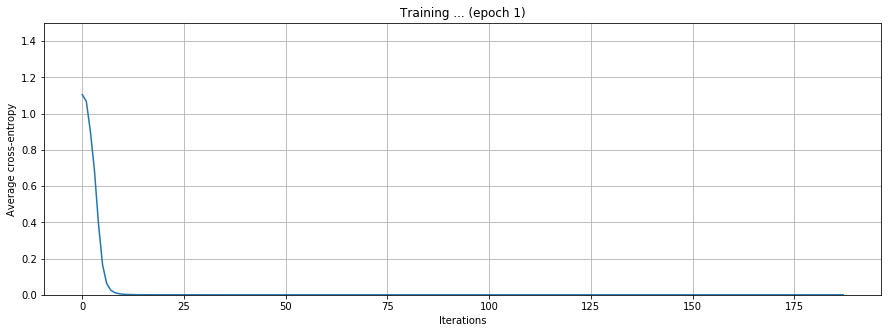

In [8]:
training_losses = []
## data = gen_data()
data = gen_data_non_random()

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for e in range(epochs): 
        batch_generator = gen_batch(data)
        for i, batch in enumerate(batch_generator): 
            init_state_ = sess.run(init_state)
            total_loss_, final_state_, _ = \
                sess.run(fetches = [total_loss, 
                                    final_state, 
                                    train_step], 
                         feed_dict = {x : batch[0], 
                                      y : batch[1], 
                                      y_next : batch[2], 
                                      init_state : init_state_})
                
            training_losses.append(total_loss_)

            if i % 10 == 0:
                clear_output(wait=True)
                plt.figure(figsize = (15,5))
                plt.ylim(0.0, 1.5)
                plt.plot(training_losses)
                plt.xlabel("Iterations")
                plt.ylabel("Average cross-entropy")
                plt.title("Training ... (epoch "+str(e)+")")
                plt.grid()
                plt.show()